(00-backprop)=
# Backpropagation

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/nn/00-backprop.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**References:**  {cite}`timviera` {cite}`backprop-offconvex` {cite}`pytorch-autograd` {cite}`micrograd`


## Introduction

In this notebook, we look into **backpropagation** (BP) on directed acyclic computational graphs (DAGs) for computing gradients. This involves breadth-first message passing of activations in the forward pass, and local gradients in the backward pass. The resulting time complexity is linear in the number of size of the network, i.e. the number of weights and neurons for neural nets. Neural networks are computational DAGs with differentiable nodes. This fact allows scaling training large neural networks. We will implement a minimal scalar-valued **autograd engine** and a neural net library on top it to train a small regression model as proof-of-concept.

## BP on computational graphs

A neural network can be modelled as a **directed acyclic graph** (DAG) of nodes that implements a function. During training, this is extended to implement the calculation of the loss. There are generally three type of node groups: **compute nodes**, **input nodes**, and **parameter nodes**. Compute nodes simply implement a simple function of values of nodes that are directed to it. These are not necessarily atomic functions. Parameter nodes and input nodes simply store values.

```{figure} ../../img/compute.svg
---
width: 30%
name: compute
---
Compute and parameter node as input to another compute node. Note that parameter nodes always have zero fan-in.
```

**Remark.** Recall from the previous notebook that our goal is to obtain parameter node values $\hat{\boldsymbol{\Theta}}$ after optimization (e.g. with SGD) such that the $f_{\hat{\boldsymbol{\Theta}}}$ minimizes the expected value of a loss function $\ell.$ Backpropagation allows us to efficiently compute $\nabla_{\boldsymbol{\Theta}} \ell$ for SGD after $(\boldsymbol{\mathsf{x}}, y) \in \mathcal{B}$ is passed to the input nodes.

### Forward pass

During forward pass all compute nodes are executed starting from the input nodes, which evaluates to the input vector $\boldsymbol{\mathsf x}.$ This passed to its child nodes, and so on up to the loss node. The output value of each node is stored to avoid recomputation for child nodes that depend on the same node. This also preserves the network state for backward pass. Finally, forward pass builds the computational graph which is stored in memory. This will be seen later in the practical demo. 

**Remark.** Note that nodes which compute values independently of each other can execute in parallel (e.g. neurons in a dense layer). This parallelism can occur both in the batch dimension and the layer dimension. Operations which can be expressed as tensor operations can leverage massive parallelism in the GPU. Later we will see that the same is true for backward pass which can be expressed in terms of matrix multiplications!

### Backward pass

Backward pass computes gradients starting from the loss node $\ell$ down 
to the input nodes $\boldsymbol{\mathsf{x}}.$ 
The gradient of $\ell$ with respect to itself is $1$. This serves as the base step.
For any other node $u$ in the graph, we can assume that the **global gradient**
${\partial \ell}/{\partial v}$ is cached for each node $v \in N(u)$, where $N(u)$ are all nodes 
in the graph that depend on $u$. On the other hand, the **local gradient**
${\partial v}/{\partial u}$ between adjacent nodes is specified 
analytically based on the functional
dependence of $v$ upon $u.$ These are computed at runtime given current node values
cached during forward pass.

The global gradient with respect to node $u$ can then be inductively calculated using the chain 
rule:
$\frac{\partial \ell}{\partial u} = \sum_{v \in N(u)} \frac{\partial \ell}{\partial v} \frac{\partial v}{\partial u}.$
This can be visualized as gradients flowing from the loss node to each network node. 
The flow of gradients will end on parameter and input nodes which depend on no other
nodes. Hence, the algorithm terminates.

```{figure} ../../img/backward-1.svg
---
width: 80%
name: backward-1
---
Computing the global gradient for a single node. Note that gradient type is distinguished by color: **local** (red) and **global** (blue).
```

This can be visualized as gradients flowing to each network node from the loss node. The flow of gradients will end on parameter and input nodes which have zero fan-in. Global gradients are stored in each compute node in the `.grad` attribute for use by the next layer, along with node values obtained during forward pass which are used in local gradient computation. Memory can be released after the weights are updated. On the other hand, there is no need to store local gradients as these are computed as needed. Backward pass can be implemented roughly as follows:

```python
class CompGraph:
    # ...

    def backward():
        for node in self.nodes():
            node.grad = None

        self.loss_node.grad = 1.0
        self.loss_node.backward()


class Node:
    # ...

    def backward(self):
        for parent in self.parents:
            parent.grad += self.grad * self.local_grad(parent)
            parent.degree -= 1
            if parent.degree == 0:
                parent.backward()
```

Each node has to wait for all incoming gradients from dependent nodes before passing the gradient to its parents. This is done by having a `degree` attribute that tracks whether all gradients from its dependent nodes have accumulated to a parent node. A newly created node starts with zero degree and is incremented each time a child node is created from it. In particular, the loss node has degree zero. Here `self.grad` is the global gradient which is equal to `∂L/∂(self)` while the local gradient `self.local_grad` is equal to `∂(self)/∂(parent)`. So this checks out with the chain rule. See {numref}`03-parent-child-nodes` below.

```{figure} ../../img/nn/03-parent-child-nodes.png
---
width: 100%
name: 03-parent-child-nodes
---
Equivalent ways of computing the global gradient. On the left, the global gradient is computed by tracking the dependencies from $u$ to each of its child node during forward pass. This is our formal statement before. Algorithmically, we start from each node in the upper layer. So instead, we contribute one term in the sum to each parent node. Eventually, all terms in the chain rule is accumulated and the parent node fires, sending gradients to its parent nodes in the next layer.
```

**Modularity.** BP is a useful tool for reasoning about gradient flow and can suggest ways to improve training or network design. Moreover, since it only requires local gradients between nodes, BP allows modularity when creating deep networks. 
In other words, we can arbitrarily connect layers with different architectures as long as the operations and their gradients are locally defined. 

**Runtime.** Note that each edge is the DAG is passed exactly once ({numref}`03-parent-child-nodes`). Hence, the time complexity of solving for the global gradients is $O(E)$ where $E$ is the number of edges in the graph. For fully-connected neural networks, assuming each compute node evaluation and local gradient is constant time, then $E = M + V$ where $M$ is the number of weights and $V$ is the number of activations. It follows that one backward pass for an instance is proportional to the network size. Note that this can be parallelized due to independence. 

**Memory.** Memory requirement for a training step seems to be $O(2E)$ since we have to store both gradients and values. But this can be improved by releasing memory of the previous layer once a layer finishes computing its gradient.

## Creating and training a neural net from scratch

Recall that all operations must be defined with its local gradient specified for efficient BP to work. In this section, we will implement a minimal **autograd engine** for creating computational graphs. This starts with the base `Node` class which has a `.data` attribute for storing output and a `.grad` attribute for storing the global gradient. The base class defines a `backward` method to solve for `.grad` as described above.

Note that the node class does not implement a local gradient. Instances of the node class, such as input nodes and network weights, are called **leaf nodes**. Nodes implement all operations and activations which are inherited by outputs of these computations which we call **compute nodes**. The formula for local gradient in `_local_grad` must be implemented with respect to each parent node of the compute node.

In [1]:
import math
import random
random.seed(42)

from typing import final


class Node:
    def __init__(self, data, parents=()):
        self.data = data
        self.grad = 0             # ∂(loss)/∂(self)
        self._degree = 0          # no. of children
        self._parents = parents   # terminal node 

    @final
    def backward(self):
        """Send global grads backward to parent nodes."""
        for parent in self._parents:
            parent.grad += self.grad * self._local_grad(parent)
            parent._degree -= 1
            if parent._degree == 0:
                parent.backward()
    
    def _local_grad(self, parent) -> float: 
        """Compute local grads ∂(self)/∂(parent)."""
        raise NotImplementedError("Base node has no parents.")

    def __add__(self, other):
        self._degree += 1
        other._degree += 1
        return BinaryOpNode(self, other, op='+')

    def __mul__(self, other):
        self._degree += 1
        other._degree += 1
        return BinaryOpNode(self, other, op='*')

    def __pow__(self, n):
        assert isinstance(n, (int, float)) and n != 1
        self._degree += 1
        return PowOp(self, n)

    def relu(self):
        self._degree += 1
        return ReLUNode(self)

    def tanh(self):
        self._degree += 1
        return TanhNode(self)

    def __neg__(self):
        return self * Node(-1)

    def __sub__(self, other):
        return self + (-other)

Note that we can take advantage of reduction to minimize the operations for which we have to implement `_local_grad(self, parent)`. Below, we define the above operations between nodes. Observe that only a handful of operations are needed to implement a fully-connected neural net!

In [2]:
class BinaryOpNode(Node):
    def __init__(self, x, y, op: str):
        """Binary operation between two nodes."""
        ops = {
            '+': lambda x, y: x + y,
            '*': lambda x, y: x * y
        }
        self._op = op
        super().__init__(ops[op](x.data, y.data), (x, y)) 

    def _local_grad(self, parent):
        if self._op == '+':
            return 1.0
                    
        elif self._op == '*':
            i = self._parents.index(parent)
            coparent = self._parents[1 - i]
            return coparent.data

    def __repr__(self):
        return self._op


class ReLUNode(Node):
    def __init__(self, x):
        data = x.data * int(x.data > 0.0)
        super().__init__(data, (x,))

    def _local_grad(self, parent):
        return float(parent.data > 0)

    def __repr__(self):
        return 'relu'


class TanhNode(Node):
    def __init__(self, x):
        data = math.tanh(x.data)
        super().__init__(data, (x,))

    def _local_grad(self, parent):
        return 1 - self.data**2

    def __repr__(self):
        return 'tanh'


class PowOp(Node):
    def __init__(self, x, n):
        self.n = n
        data = x.data ** self.n
        super().__init__(data, (x,))

    def _local_grad(self, parent):
        return self.n * parent.data ** (self.n - 1)

    def __repr__(self):
        return f"** {self.n}"

### Graph vizualization

The next two functions help to visualize networks. The `trace` function just walks backward into the graph to collect all nodes and edges. This is used by the `draw_graph` which first draws all nodes, then draws all edges. For compute nodes we add a small juncture node which contains the name of the operation.

In [3]:
# https://github.com/karpathy/micrograd/blob/master/trace_graph.ipynb
from graphviz import Digraph

def trace(root):
    """Builds a set of all nodes and edges in a graph."""

    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._parents:
                edges.add((child, v))
                build(child)
                    
    build(root)
    return nodes, edges


def draw_graph(root):
    """Build diagram of computational graph."""
    
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:

        # Add node to graph    
        uid = str(id(n))
        dot.node(name=uid, label=f"data={n.data:.3f} | grad={n.grad:.4f} | deg={n._degree}", shape='record')
        
        # Connect node to op node if operation
        # e.g. if (5) = (2) + (3), then draw (5) as (+) -> (5).
        if len(n._parents) > 0:
            dot.node(name=uid+str(n), label=str(n))
            dot.edge(uid+str(n), uid)

    for child, v in edges:
        # Connect child to the op node of v
        dot.edge(str(id(child)), str(id(v)) + str(v))
    
    return dot

Creating graph for a dense unit. Observe that `x1` has a degree of 2 since it has two children.

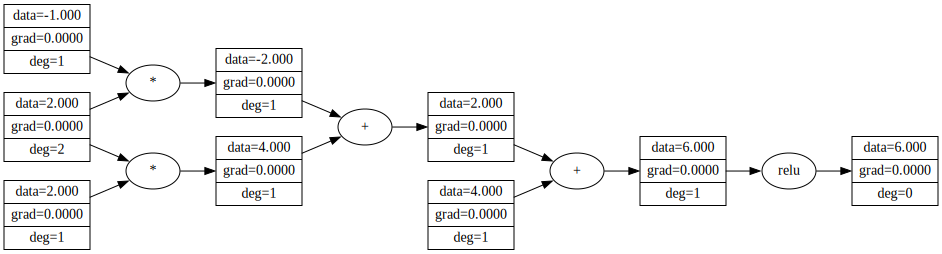

In [4]:
w1 = Node(-1.0)
w2 = Node(2.0)
b  = Node(4.0)
x  = Node(2.0)
t  = Node(3.0)

z = w1 * x + w2 * x + b
y = z.relu()
draw_graph(y)

Backward pass can be done by setting the initial gradient of the final node, then calling backward on it. Recall for the loss node `loss.grad = 1.0`. Observe that all gradients check out. Also, all degrees are zero, which means we did not overshoot the updates. This also means we can't execute `.backward()` twice.

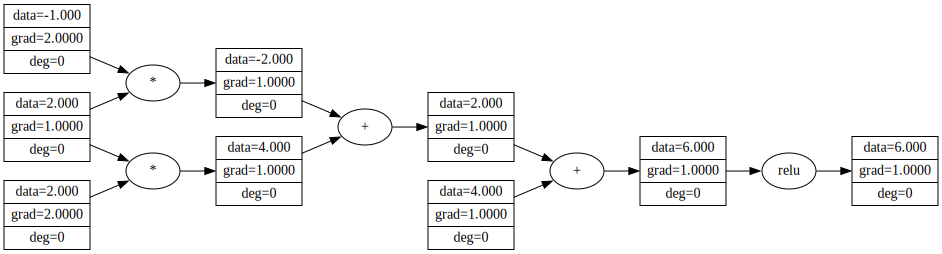

In [5]:
y.grad = 1.0
y.backward()
draw_graph(y)

### Neural network

In this section, we construct the neural network module. Here `Module` defines an abstract class which maintains a list of the parameters used in forward pass implemented in `__call__`. The decorator `@final` is to say that the inheriting class from overriding the methods. Doing so would result in a warning (or an error with a type checker). The `_parameters` attribute is defined so that the parameter list is not constructed at each call of the `parameters()` method.

In [6]:
from abc import ABC, abstractmethod

class Module(ABC):
    def __init__(self):
        self._parameters = []

    @final
    def parameters(self) -> list:
        return self._parameters

    @abstractmethod
    def __call__(self, x: list):
        pass

    @final
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

Implementing layers from neurons:

In [7]:
import numpy as np
np.random.seed(42)


class Neuron(Module):
    def __init__(self, n_in, nonlinear=True, activation='relu'):
        self.n_in = n_in
        self.act = activation
        self.nonlin = nonlinear

        self.w = [Node(random.random()) for _ in range(n_in)]
        self.b = Node(0.0)
        self._parameters = self.w + [self.b] 

    def __call__(self, x: list):
        assert len(x) == self.n_in
        out = sum((x[j] * self.w[j] for j in range(self.n_in)), start=self.b)
        if self.nonlin:
            if self.act == 'tanh':
                out = out.tanh()
            elif self.act == 'relu':
                out = out.relu()
            else:
                raise NotImplementedError("Activation not supported.")
        return out

    def __repr__(self):
        return f"{self.act if self.nonlin else 'linear'}({len(self.w)})"


class Layer(Module):
    def __init__(self, n_in, n_out, *args):
        self.neurons = [Neuron(n_in, *args) for _ in range(n_out)]
        self._parameters = [p for n in self.neurons for p in n.parameters()]

    def __call__(self, x: list):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def __repr__(self):
        return f"Layer[{', '.join(str(n) for n in self.neurons)}]"


class MLP(Module):
    def __init__(self, n_in, n_outs, activation='relu'):
        sizes = [n_in] + n_outs
        self.layers = [Layer(sizes[i], sizes[i+1], i < len(n_outs)-1, activation) for i in range(len(n_outs))]
        self._parameters = [p for layer in self.layers for p in layer.parameters()]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def __repr__(self):
        return f"MLP[{', '.join(str(layer) for layer in self.layers)}]"

Testing model init and model call. Note that final node has no activation:

In [8]:
model = MLP(n_in=1, n_outs=[2, 2, 1])
print(model)
x = Node(1.0)
pred = model([x])
print(pred.data)

MLP[Layer[relu(1), relu(1)], Layer[relu(2), relu(2)], Layer[linear(2)]]
0.20429304314825944


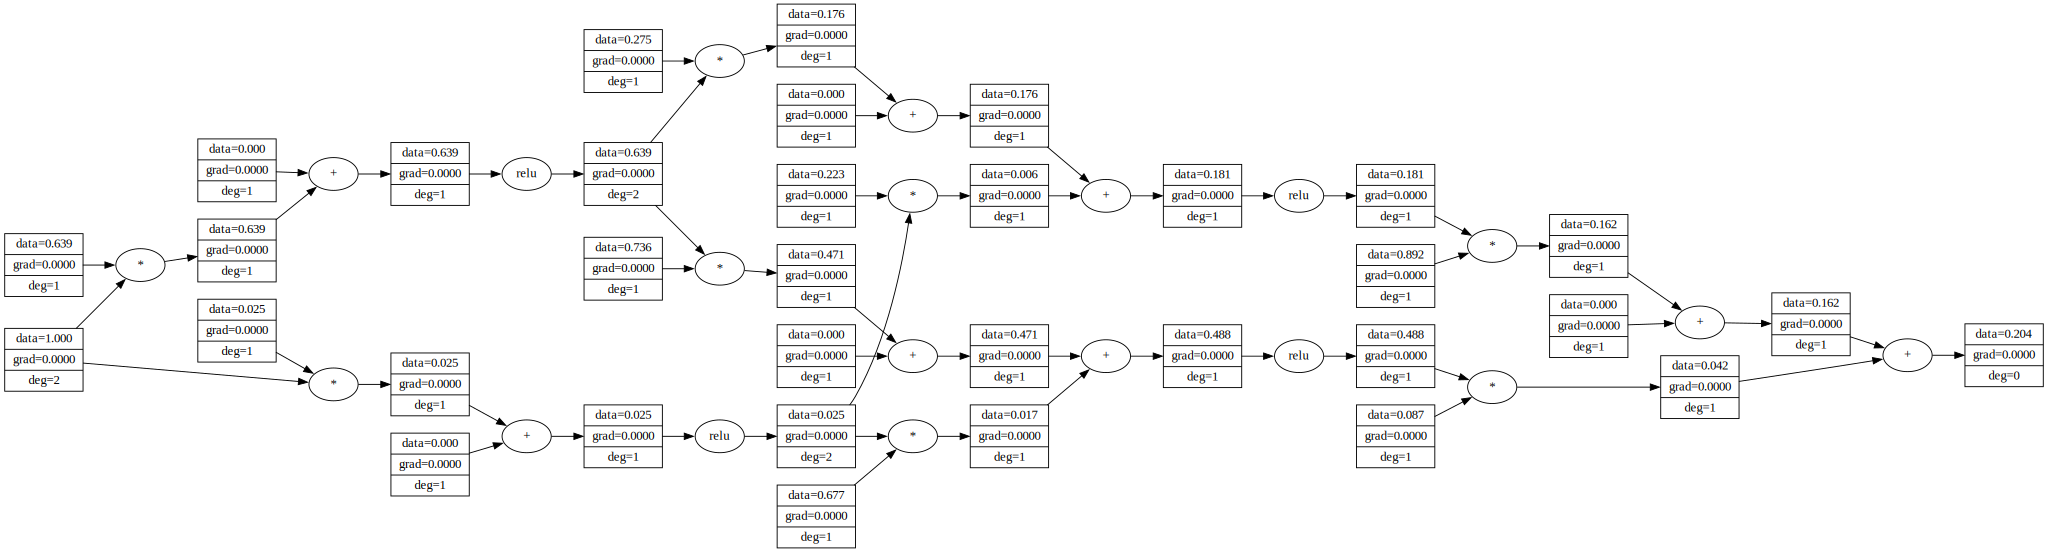

In [9]:
draw_graph(pred)

(00-nn-benchmark)=
### Benchmarking

Recall BP has time and memory complexity that is **linear** in the network size. This assumes each node executes in constant time and the outputs are stored. Moreover, the gradient should never be asymptotically slower than the function assuming local gradient computation takes constant time. Testing this here empirically.

100%|██████████| 14/14 [03:59<00:00, 17.12s/it]


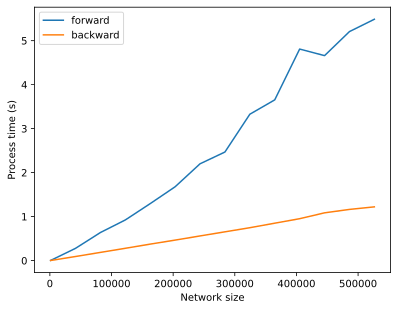

In [10]:
import tqdm
import time
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')


x = [Node(1.0)] * 3
network_size  = []
forward_time  = []
backward_time = []

for i in tqdm.tqdm(range(1, 15)):
    nouts = [200] * i + [1]
    model = MLP(n_in=3, n_outs=nouts)
    
    f_timings = []
    b_timings = []
    
    for i in range(5):
        start = time.process_time()
        pred = model(x)
        end = time.process_time()
        f_timings.append(end - start)

        pred.grad = 1.0
        start = time.process_time()
        pred.backward()
        end = time.process_time()
        b_timings.append(end - start)

    network_size.append(len(model.parameters()) + sum(nouts) + 3)
    forward_time.append(sum(f_timings[1:]) / 4)
    backward_time.append(sum(b_timings[1:]) / 4)


plt.plot(network_size, forward_time, label='forward')
plt.plot(network_size, backward_time, label='backward')
plt.xlabel("Network size")
plt.ylabel("Process time (s)")
plt.legend();

**Figure.** Roughly linear time complexity in network size for both forward and backward passes.

### Training the network!

**Dataset.** Our task is to learn from noisy data points around a true curve:

In [11]:
N = 300
time = np.linspace(-3, 3, N)
y_signal = time + np.sin(np.pi * time)
y_data = y_signal + 0.1 * np.random.normal(size=N)

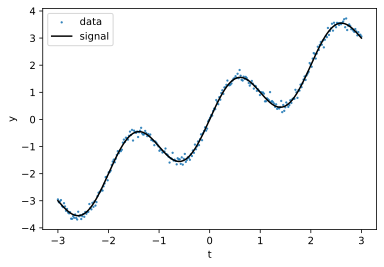

In [12]:
plt.figure(figsize=(6, 4))
plt.scatter(time, y_data, label='data', s=2, alpha=0.8)
plt.plot(time, y_signal, label='signal', color='black')
plt.ylabel('y')
plt.xlabel('t')
plt.legend();

**Data loader.** Helper for loading the samples:

In [13]:
import random

class DataLoader:
    def __init__(self, dataset):
        """Iterate over a partition of the dataset."""
        self.dataset = [(Node(x), Node(y)) for x, y in dataset]
    
    def load(self):
        return random.sample(self.dataset, len(self.dataset))

    def __len__(self):
        return len(self.dataset)

**Training.** The function `optim_step` implements one step of SGD with batch size 1. Here `loss_fn` just computes the MSE between two nodes.

In [14]:
def optim_step(model, eps):
    for p in model.parameters():
        p.data -= eps * p.grad 

def loss_fn(y_pred, y_true):
    return (y_pred - y_true)**2

Running the training algorithm:

In [15]:
def train(model, dataset, epochs):
    dataloader = DataLoader(dataset)
    history = []
    for _ in tqdm.tqdm(range(epochs)):
        for x, y in dataloader.load():
            model.zero_grad()
            
            loss = loss_fn(model([x]), y)
            loss.grad = 1.0
            loss.backward()
            optim_step(model, eps=0.0001)

            history.append(loss.data)

    return history


dataset = list(zip(time, y_data))
model = MLP(1, [3, 3, 1], 'tanh')
loss = train(model, dataset, epochs=15000)

  0%|          | 2/15000 [00:00<16:42, 14.97it/s]

100%|██████████| 15000/15000 [08:09<00:00, 30.67it/s]


Observe that the loss curve becomes more stable as we train futher:

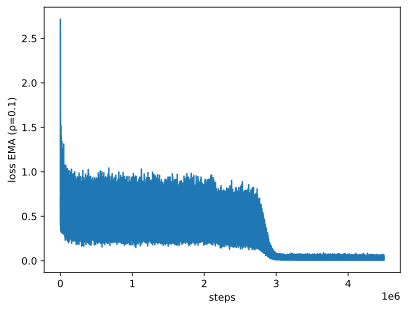

In [16]:
ρ = 0.1
loss_ema = [loss[0]]
for i in range(1, len(loss)):
    loss_ema.append(loss_ema[i-1] * (1 - ρ) + loss[i] * ρ)

plt.plot(loss_ema)
plt.ylabel(f"loss EMA (ρ={ρ})")
plt.xlabel("steps");

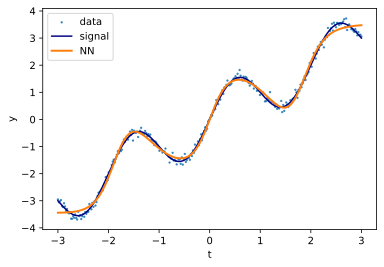

In [17]:
plt.figure(figsize=(6, 4))
plt.scatter(time, y_data, label='data', s=2, alpha=0.8)
plt.plot(time, y_signal, label='signal', color='navy')
plt.plot(time, [model([Node(_)]).data for _ in time], label='NN', color='C1', linewidth=2)

plt.ylabel('y')
plt.xlabel('t')
plt.legend();

Evaluating with MAE since values are in (0, 1):

In [18]:
y_pred = np.array([model([Node(_)]).data for _ in time])
print(f"MAE (data)  = {np.abs(y_data - y_signal).mean():.2f}")
print(f"MAE (model) = {np.abs(y_pred - y_signal).mean():.2f}")

MAE (data)  = 0.08
MAE (model) = 0.10


## Appendix: Testing with `autograd`

The `autograd` package allows automatic differentiation by building computational graphs on the fly every time we pass data through our model. Autograd tracks which data combined through which operations to produce the output. This allows us to take derivatives over ordinary imperative code. This functionality is consistent with the memory and time requirements outlined above for BP.

**Scalars.** Here we calculate $\mathsf{y} = \boldsymbol{\mathsf x}^\top \boldsymbol{\mathsf x} = \sum_i {\boldsymbol{\mathsf{x}}_i}^2$ where the initialized tensor $\boldsymbol{\mathsf{x}}$ initially has no gradient (i.e. `None`). Calling backward on $\mathsf{y}$ results in gradients being stored on the leaf tensor $\boldsymbol{\mathsf{x}}.$ Note that unlike our implementation, there is no need to set `y.grad = 1.0`. Moreover, doing so would result in an error as $\mathsf{y}$ is not a [leaf node](https://pytorch.org/docs/stable/generated/torch.Tensor.is_leaf.html) in the graph.

In [19]:
import torch
import torch.nn.functional as F
print(torch.__version__)

2.0.0


In [20]:
x = torch.arange(4, dtype=torch.float, requires_grad=True)
print(x.grad)

y = x.reshape(1, -1) @ x 
y.backward() 
print((x.grad == 2*x).all().item())

None
True


**Vectors.** Let $\boldsymbol{\mathsf y} = g(\boldsymbol{\mathsf x})$ and let $\boldsymbol{{\mathsf v}}$ be a vector having the same length as $\boldsymbol{\mathsf y}.$ Then `y.backward(v)` calculates
$\sum_i {\boldsymbol{\mathsf v}}_i \frac{\partial {\boldsymbol{\mathsf y}}_i}{\partial {\boldsymbol{\mathsf x}}_j}$
resulting in a vector of same length as $\boldsymbol{\mathsf{x}}$ stored in `x.grad`. Note that the terms on the right are the local gradients. Setting ${\boldsymbol{\mathsf v}} = \frac{\partial \mathcal{L} }{\partial \boldsymbol{\mathsf y}}$ gives us the vector $\frac{\partial \mathcal{L} }{\partial \boldsymbol{\mathsf x}}.$ Below $\boldsymbol{\mathsf y}(\boldsymbol{\mathsf x}) = [x_0, x_1].$

In [21]:
x = torch.rand(size=(4,), dtype=torch.float, requires_grad=True)
v = torch.rand(size=(2,), dtype=torch.float)
y = x[:2]

# Computing the Jacobian by hand
J = torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0]], dtype=torch.float
)

# Confirming the above formula
y.backward(v)
(x.grad == v @ J).all()

tensor(True)

**Remark.** Gradient computation is not useful for tensors that is not part of backprop. Hence, we can wrap our code in a `torch.no_grad()` context or inside a function with a `@torch.no_grad()` decorator. Note that the `.detach()` method returns a new tensor detached from the current graph but shares the same storage with the original one. In-place modifications on either tensor can result in subtle bugs.

### Testing

Finally, we write our tests with `autograd` to check the correctness of our implementation:

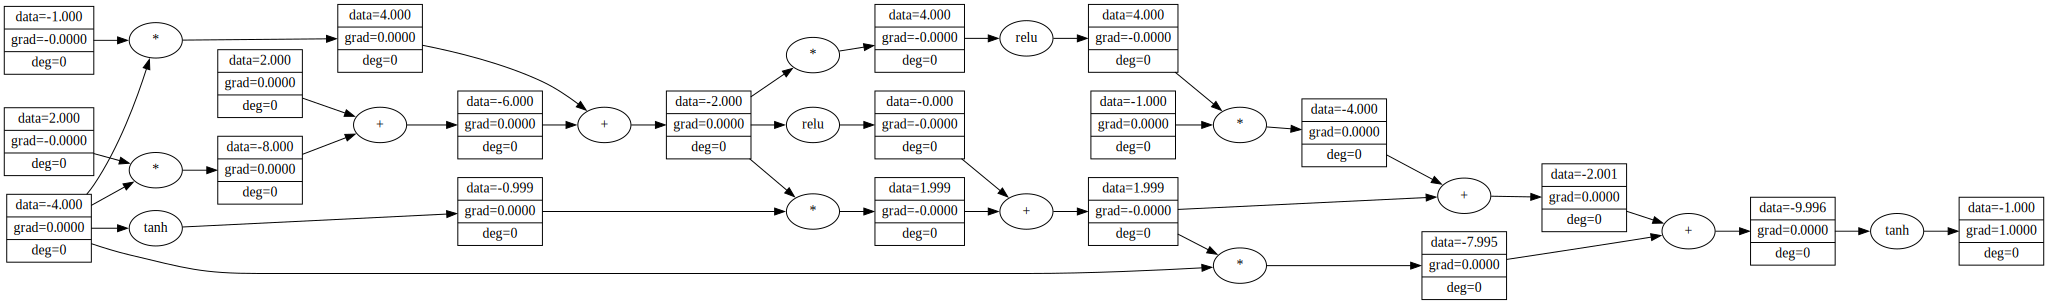

In [22]:
x = Node(-4.0)
z = Node(2) * x + Node(2) - x
q = z.relu() + z * x.tanh()
h = (z * z).relu()
y = (-h + q + q * x).tanh()
y.grad = 1.0
y.backward()

x_node, y_node, z_node = x, y, z
draw_graph(y_node)

In [23]:
x = torch.tensor(-4.0, requires_grad=True)
z = 2 * x + 2 - x
q = z.relu() + z * x.tanh()
h = (z * z).relu()
y = (-h + q + q * x).tanh()

z.retain_grad()
y.retain_grad()
y.backward()

x_torch, y_torch, z_torch = x, y, z

# forward
errors = []
errors.append(abs(x_node.data - x_torch.item()))
errors.append(abs(y_node.data - y_torch.item()))
errors.append(abs(z_node.data - z_torch.item()))

# backward
errors.append(abs(x_node.grad - x_torch.grad.item()))
errors.append(abs(y_node.grad - y_torch.grad.item()))
errors.append(abs(z_node.grad - z_torch.grad.item()))

print(f"Max absolute error: {max(errors):.2e}")

Max absolute error: 7.48e-08


(00-backprop:appendix-backpropagation-equations-for-mlps)=
## Appendix: BP equations for MLPs

Recall that a dense layer with weights $\boldsymbol{\mathsf{w}}_j \in \mathbb{R}^d$ 
and bias ${b}_j \in \mathbb{R}$ computes given an input $\boldsymbol{\mathsf{x}} \in \mathbb{R}^d$
the following equations for $j = 1, \ldots, h$ where $h$ is the layer width:
```{math}
:label: fully-connected-layer
\begin{aligned}
    z_j &= \boldsymbol{\mathsf{x}} \cdot \boldsymbol{\mathsf{w}}_j + {b}_j \\
    y_j &= \phi\left( z_j \right) \\
\end{aligned}
```
Given global gradients 
$\partial \ell / \partial y_j$
that flow into the layer, we compute the global gradients of the nodes 
$\boldsymbol{\mathsf{z}}$, $\boldsymbol{\mathsf{w}}$, $\boldsymbol{\mathsf{b}}$, and $\boldsymbol{\mathsf{x}}$
in the layer. 
As discussed above, this can be done by tracking backward dependencies in 
the computational graph ({numref}`fully-connected-backprop.drawio`).


```{figure} ../../img/fully-connected-backprop.drawio.svg
---
name: fully-connected-backprop.drawio
width: 50%
---
Node dependencies in compute nodes of a fully connected layer. All nodes $\boldsymbol{\mathsf{z}}_k$ depend on the node $\boldsymbol{\mathsf{y}}_j.$
```


Note that there can be cross-dependencies for activations such as softmax. 
But for typical activation functions $\phi$ its [Jacobian](https://mathworld.wolfram.com/Jacobian.html)
${J}^{\phi}_{kj} = \frac{\partial y_k}{\partial z_j}$ 
reduces to a diagonal matrix. Following backward dependencies 
for the compute nodes. Note that the second equation uses the computed gradients for the output nodes:

```{math}
\begin{align}
\frac{\partial \ell}{\partial {z}_j} &= \sum_k \frac{\partial \ell}{\partial {y}_k}  \frac{\partial {y}_k}{\partial {z}_j} =  \sum_k \frac{\partial \ell}{\partial {y}_k} {J}^{\phi}_{kj} \\
\frac{\partial \ell}{\partial {x}_i} &= \sum_j \frac{\partial \ell}{\partial {z}_j} \frac{\partial {z}_j}{\partial {x}_i} = \sum_j \frac{\partial \ell}{\partial {z}_j} {w}_{ij} = \sum_j \frac{\partial \ell}{\partial {z}_j} {w}_{ji}^{\top}.
\end{align}
```

Next, we compute gradients for the parameter nodes:

```{math}
\begin{align}
\frac{\partial \ell}{\partial{w}_{ij}} 
&= \frac{\partial \ell}{\partial{z}_{j}} \frac{\partial{z}_{j}}{\partial{w}_{ij}} 
= {x}_{i} \frac{\partial \ell}{\partial{z}_{j}} \label{eq:gradient_weight} \\
\frac{\partial \ell}{\partial{b}_{j}} 
&= \frac{\partial \ell}{\partial{z}_{j}}  \frac{\partial{z}_{j}} {\partial{b}_{j}} 
= \frac{\partial \ell}{\partial{z}_{j}}. \label{eq:gradient_bias}
\end{align}
```

Observe the dependence of the weight gradient on the input makes it sensitive to scaling.
This can introduce an effective scalar factor to the learning rate that is specific to 
each input dimension, making SGD diverge at early stages of training. This motivates
network input normalization and layer output normalization.

### Batch computation

Let $B$ be the batch size. Processing a batch of inputs in parallel, in principle, creates a graph 
consisting of $B$ copies of the original computational graph that share the same parameters. 
The outputs of these combine to form the loss node $\mathcal{L} = \frac{1}{B}\sum_b \ell_b.$ For usual activations, $\boldsymbol{\mathsf{J}}^\phi = \text{diag}(\phi^\prime(\boldsymbol{\mathsf{z}}))$. The output and input gradients can be written in the following matrix notation for fast computation:

```{math}
:label: backprop-output
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Z}}} &= \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Y}}} \odot {\phi}^{\prime}(\boldsymbol{\mathsf{Z}})
\end{aligned}
```

```{math}
:label: backprop-input
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{X}}} &= \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Z}}}\, \boldsymbol{\mathsf{W}}^\top \hspace{18pt}
\end{aligned}
```

These correspond to the equations above since there is no dependence across batch instances. Note that the stacked output tensors $\boldsymbol{\mathsf{Z}}$ and $\boldsymbol{\mathsf{Y}}$ have shape $(B, h)$ where $h$ is the layer width and $B$ is the batch size. The stacked input tensor $\boldsymbol{\mathsf{X}}$ has shape $(B, d)$ where $d$ is the input dimension. Finally, the weight tensor $\boldsymbol{\mathsf{W}}$ has shape $(d, h).$ For the weights, the contribution of the entire batch have to be accumulated ({numref}`weight-backprop.drawio`):

```{math}
:label: backprop-weights
\begin{align}
\frac{\partial \mathcal{L}}{\partial{\boldsymbol{\mathsf{W}}}} 
= \boldsymbol{\mathsf{X}}^\top \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Z}}}. \hspace{30pt}
\end{align}
```

```{math}
:label: backprop-bias
\begin{align}
\frac{\partial \mathcal{L}}{\partial{\boldsymbol{\mathsf{b}}}} 
= [1, \ldots, 1] \, \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Z}}}.
\end{align}
```

**Remark.** One way to remember these equations is that the shapes must check out.

```{figure} ../../img/weight-backprop.drawio.svg
---
name: weight-backprop.drawio
width: 30%
---
Node dependencies for a weight node. The nodes $\boldsymbol{\mathsf{z}}_{bj}$ depend on $\boldsymbol{\mathsf{w}}_{ij}$ for $b = 1, \ldots, B.$
```

### Cross entropy

In this section, we compute the gradient across the **cross-entropy loss**.
This can be calculated using backpropagation, but we will derive it 
symbolically to get a closed-form formula. Recall that cross-entropy loss computes
for logits $\boldsymbol{\mathsf{s}}$:

$$
\begin{aligned}
\ell 
&= -\log \frac{\exp({s_{y}})}{\sum_{k=1}^m \exp({{s}_{k}})} \\
&= - s_{y} + \log \sum_{k=1}^m \exp({s_k}).
\end{aligned}
$$

Calculating the derivatives, we get

$$
\begin{aligned}
\frac{\partial \ell}{\partial s_j} 
&= - \delta_{yj} + \frac{\exp({s_j})}{\sum_{k=1}^m \exp({s_k})} \\ \\
&= - \delta_{yj} + \text{softmax}(s_j) = 
\left\{
\begin{array}{l}
p_j \quad \quad\;\;\; \text{if $\;j \neq y$}\\
p_y - 1 \quad \text{else}\\
\end{array}
\right.
\end{aligned}
$$

where $\delta_{yj}$ is the [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta).
This makes sense: having output values in nodes that do not correspond 
to the true class only contributes to increasing the loss. On the other hand,
increasing values in the node for the true class results in decreasing loss.
This effect is strong if the current network output has $s_y - s_{j^*} \ll 0$ where 
$j^* = \text{arg max}_j\, s_j.$ Conversely, as 
$\text{softmax}(\boldsymbol{\mathsf{s}}) \approx \mathbf{1}_y,$ then
${\partial \ell}/{\partial \boldsymbol{\mathsf{s}}}$ becomes close to the zero vector, 
so that $\nabla_{\boldsymbol{\Theta}} \ell$ is also close to zero.

The gradient of the logits ${\boldsymbol{\mathsf{S}}}$ can be written in matrix form
where $\mathcal{L} = \frac{1}{B}\sum_b \ell_b$:

```{math}
:label: backprop-cross-entropy
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial {\boldsymbol{\mathsf{S}}}} 
&= - \frac{1}{B} \left ( \boldsymbol{\delta} - \text{softmax}({\boldsymbol{\mathsf{S}}}) \right)
\end{aligned}
```

**Remark.** Examples with similar features but different labels can contribute to a smoothing between 
the labels of the predicted probability vector. This is nice since we can use the probability
value as a measure of confidence. We should also expect a noisy loss curve in the presence of significant label noise.

### Gradient checking

Computing the cross-entropy for a batch:

In [24]:
B = 32
N = 27

# forward pass
t = torch.randint(low=0, high=N, size=(B,))
x = torch.randn(B, 128, requires_grad=True)
w = torch.randn(128, N, requires_grad=True)
b = torch.randn(N,      requires_grad=True)
z = x @ w + b
y = torch.tanh(z)

for node in [x, w, b, z, y]:
    node.retain_grad()

# backprop batch loss
loss = -torch.log(F.softmax(y, dim=1)[range(B), t]).sum() / B
loss.backward()

Plotting the gradient of the logits:

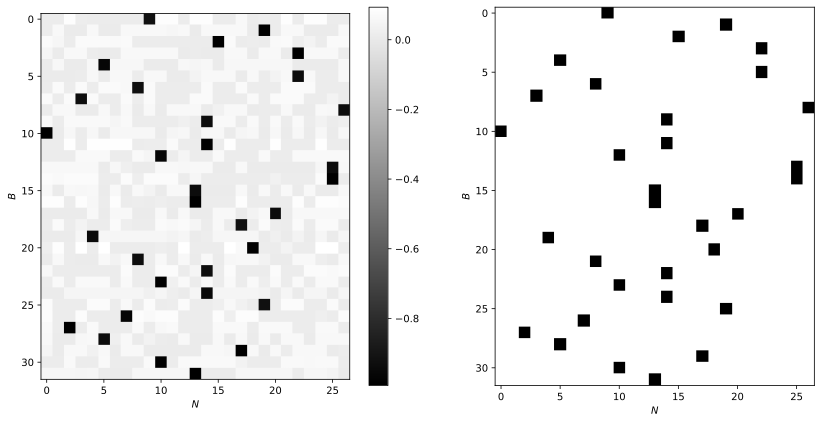

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
c = ax[0].imshow(y.grad.detach().numpy() * B, cmap='gray')
ax[1].imshow(-F.one_hot(t, num_classes=N).detach().numpy(), cmap='gray')
ax[0].set_ylabel("$B$")
ax[1].set_ylabel("$B$")
ax[0].set_xlabel("$N$")
ax[1].set_xlabel("$N$")
plt.colorbar(c, ax=ax[0])
fig.tight_layout();

**Figure.** Gradient of the logits for given batch (left) and actual targets (right). Notice the sharp contribution to decreasing loss by increasing the logit of the correct class. Other nodes contribute to increasing the loss. It's hard to see, but incorrect pixels have positive values that sum to the pixel value in the target. Checking this to ensure correctness:

In [26]:
y.grad.sum(dim=1, keepdim=True).abs().mean()

tensor(2.1428e-09)

Recall that the above equations were vectorized with the convention that the gradient with respect to a tensor $\boldsymbol{\mathsf{v}}$ has the same shape as $\boldsymbol{\mathsf{v}}.$ In PyTorch, `v.grad` is the global gradient with respect to `v` of the tensor that called `.backward()` (i.e. `loss` in our case). The following computation should give us an intuition of how gradients flow backwards through the neural net starting from the loss to all intermediate results:

In [27]:
J = 1 - y**2                                    # Jacobian
δ_tk = F.one_hot(t, num_classes=N)              # Kronecker delta
dy = - (1 / B) * (δ_tk - F.softmax(y, dim=1))   # logits grad
dz = dy * J
dx = dz @ w.T
dw = x.T @ dz
db = dz.sum(0, keepdim=True)

Refer to {eq}`backprop-cross-entropy`, {eq}`backprop-output`, {eq}`backprop-input`, {eq}`backprop-weights`, and {eq}`backprop-bias` above. These equations can be checked using `autograd` as follows:

In [28]:
def compare(name, dt, t):
    exact  = torch.all(dt == t.grad).item()
    approx = torch.allclose(dt, t.grad, rtol=1e-5)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{name:<3s} | exact: {str(exact):5s} | approx: {str(approx):5s} | maxdiff: {maxdiff:.2e}')


compare('y', dy, y)
compare('z', dz, z)
compare('x', dx, x)
compare('w', dw, w)
compare('b', db, b)

y   | exact: False | approx: True  | maxdiff: 1.86e-09
z   | exact: False | approx: True  | maxdiff: 1.86e-09
x   | exact: False | approx: True  | maxdiff: 7.45e-09
w   | exact: False | approx: True  | maxdiff: 7.45e-09
b   | exact: False | approx: True  | maxdiff: 1.86e-09


---

■